# Time Series Clustering and Smilarity Measurement on NYSE Data
---
<img src="https://www.marketplace.org/wp-content/uploads/2019/09/stockmarket.jpg?fit=2880%2C1621" width="500"/>

# Work Flow
## 1. Problem definition

## 2. Acquire data

## 3. Data cleaning 

## 4. Check Stationarity of Apple Stock

## 5. Apple Stock Trading Simulation
## 6. Classify similar stocks based on time series
## 7. Conclusion
- To find the time series clusters based on the magnitude -> k mean cluster with raw trend
- To find the time series clusters based on the shape of the trend -> k mean cluster with percent change
- To find the time series that has similar magnitude with a trend -> find trends with the closest euclidean distance / Dynamic Time warping
- To find the time series that has similar shape with a trend -> get the moving average and get the rate changes. Find trends with the closest euclidean distance / Dynamic Time warping.

---
## 1. Problem definition

> - Check stationarity of Apple stock

> - Check how much money we can make with one Apple Stock

> - Classify similar stocks based on time series
---

## 2. Acquire Data

In [2]:
# Data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from dtaidistance import ed


In [4]:
df = pd.read_csv("prices-split-adjusted.csv")
print(df.shape)
print(df.columns)
df.head()

(851264, 7)
Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume'], dtype='object')


,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


---
## 3. Data cleaning

First let's analyze AAPL stock and do analysis on it.

In [5]:
df_apple = df[df['symbol'] == 'AAPL']
df_apple.shape

(1762, 7)

This data contains six years of data from 2010 to 2016.

In [6]:
print(df_apple['date'].min())
print(df_apple['date'].max())

2010-01-04
2016-12-30


Change the data format to datetime format to conduct time series analysis

In [7]:
# change the format of the data
df_apple['date'] = pd.to_datetime(df['date'], format = '%Y-%m')
df_apple.head()

/var/folders/ly/yp1zttk15gsc1kxg7rl2plgr0000gn/T/ipykernel_6495/3019356605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple['date'] = pd.to_datetime(df['date'], format = '%Y-%m')


,date,symbol,open,close,low,high,volume
254,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
721,2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
1189,2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
1657,2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2125,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0


In [8]:
df_apple.index = df_apple['date']
del df_apple['date']
df_apple.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0


---
## 4. Check Stationarity of Apple Stock

### Check Stationarity

**What is Stationarity and why is it important?**

Stationarity is a way to measure if the data has structural patterns like seasonal trends. You need to check for both of these in time series data because they’re assumptions that are made by many widely used methods in time series analysis. For example, the autoregressive integrated moving average (ARIMA) method for forecasting time series assumes stationarity. Simply put, stationarity means that the manner in which time series data changes is constant. A stationary time series will not have any trends or seasonal patterns. Specifically, stationarity is assumed for a wide variety of time series forecasting methods including autoregressive moving average (ARMA), ARIMA and Seasonal ARIMA (SARIMA).

**How to check for stationarity in our data**

1) Check visually
- line plot
- decomposition

Visually check whether there are any trends or seasonal patterns

2) Statistical Test

We will use the Dickey Fuller test. 


#### 1. Check visually
- line plot

<AxesSubplot:xlabel='date', ylabel='close'>

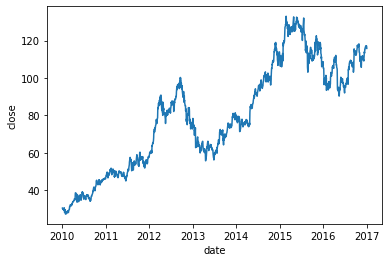

In [9]:
sns.lineplot(x=df_apple.index, y= df_apple['close'])

In [10]:
rolling_mean = df_apple['close'].rolling(90).mean()
rolling_std = df_apple['close'].rolling(90).std()

Let's overlay our time sereis with six-month rolling mean and six month rolling standard deviation.

<AxesSubplot:xlabel='date', ylabel='close'>

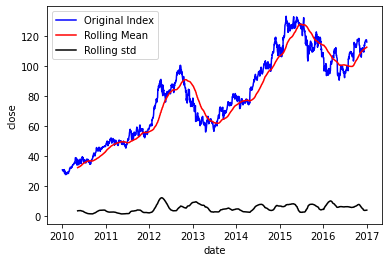

In [11]:
sns.lineplot(x=df_apple.index, y= df_apple['close'], color = 'blue', label = 'Original Index')
sns.lineplot(x=df_apple.index, y= rolling_mean, color = 'red', label = 'Rolling Mean')
sns.lineplot(x=df_apple.index, y= rolling_std, color = 'black', label = 'Rolling std')

From above we can see that there is an increasing trend and pretty steady std.

Now let's see decompose the graph to gain further insights. For this case, we will use additive model
- Decomposition


**When to use additive**

If the seasonality and residuals are independent of the trend in the plotted time series, we use an additive model to decompose the data. The additive time series model we are talking about is of the form: 

$O_t = T_t+S_t+R+t$ Where:

$O_t$ is the observed value.
$T_t$ is the trend value.
$S_t$ is the seasonality value.
$R_t$ is residual value.
$_t$ is a variable for a particular time indexing.

In [12]:
decompose = seasonal_decompose(df_apple['close'],model='additive', period=90)
estimated_trend_add = decompose.trend
estimated_seasonal_add = decompose.seasonal
estimated_residual_add = decompose.resid

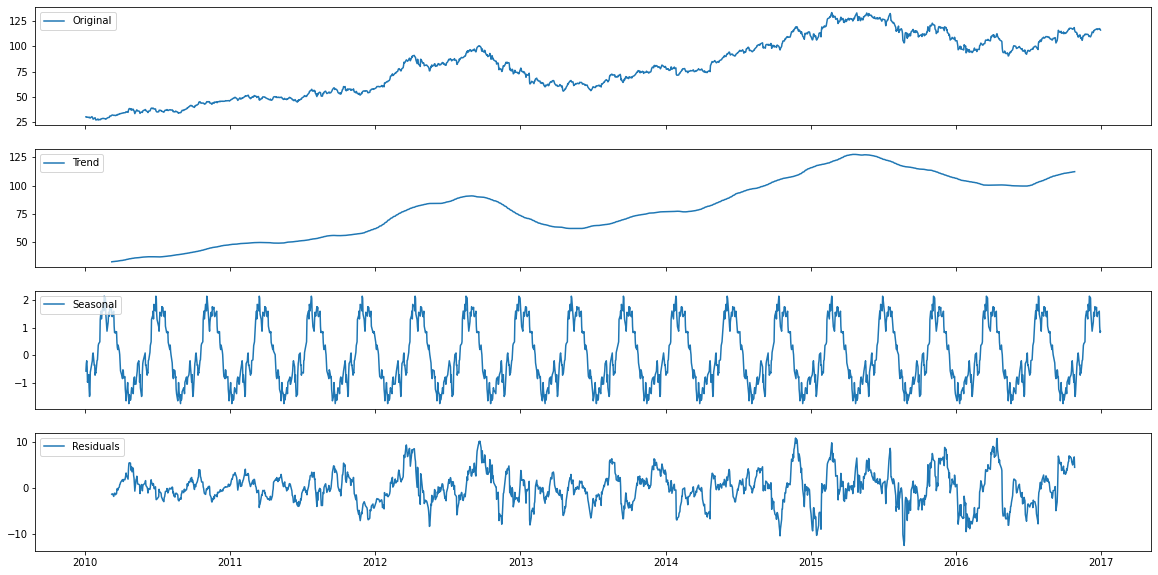

In [13]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
axes[0].plot(df_apple['close'], label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(estimated_trend_add, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(estimated_seasonal_add, label='Seasonal')
axes[2].legend(loc='upper left')

axes[3].plot(estimated_residual_add, label='Residuals')
axes[3].legend(loc='upper left')


From the decompositon plot, we can see that there is definitely an increasing trend and some minor Seasonality.

#### 2. Statistical Test
Let's import augmented Dickey-Fuller test

This test will generate critical values and a p-value, which will allow us to accept or reject the null hypothesis that there is no stationarity. If we reject the null hypothesis, that means we accept the alternative, which states that there is stationarity. Stating Again,

**Null Hypothesis:** Non stationarity exists in the series.

**Alternative Hypothesis:** Stationarity exists in the series.

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
# pass the data and specify the autolag parameter as "AIC"
adft = adfuller(df_apple['close'], autolag= 'AIC')
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

        Values                       Metric
0    -1.324458              Test Statistics
1     0.617910                      p-value
2     0.000000             No. of lags used
3  1761.000000  Number of observations used
4    -3.434069          critical value (1%)
5    -2.863183          critical value (5%)
6    -2.567645         critical value (10%)


First of all, from the simple line plot, we can visually see that there is an
With the above data, we can conclude that the dasta is not stationary since p > 0.05 and we accept the null hypothesis("it is not stationary")
Time series are stationary if they do not have trend or seasonal effects
___

## 5. Apple Stock Trading Simulation
First of all let's see when the stock increased the most and when the stock decrease the most

In [16]:
# the day it decrease and increase the most in trems of index
df_apple['change'] = df_apple['close'] - df_apple['open']

print(df_apple['change'].min())
print(df_apple[df_apple['change'] == df_apple['change'].min()].index)
print(df_apple['change'].max())
print(df_apple[df_apple['change'] == df_apple['change'].max()].index)

-7.370002999999997
DatetimeIndex(['2015-08-25'], dtype='datetime64[ns]', name='date', freq=None)
8.25
DatetimeIndex(['2015-08-24'], dtype='datetime64[ns]', name='date', freq=None)


/var/folders/ly/yp1zttk15gsc1kxg7rl2plgr0000gn/T/ipykernel_6495/826966081.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple['change'] = df_apple['close'] - df_apple['open']


Let's calculate the change rate where we calculate

change rate = (open - close) / open

In [17]:
# the day it decrease and increase the most in terms of rate
df_apple['change_rate'] = df_apple['change']/df_apple['open']
print(df_apple['change_rate'].min())
print(df_apple[df_apple['change_rate'] == df_apple['change_rate'].min()].index)
print(df_apple['change_rate'].max())
print(df_apple[df_apple['change_rate'] == df_apple['change_rate'].max()].index)

-0.06633068970992087
DatetimeIndex(['2015-08-25'], dtype='datetime64[ns]', name='date', freq=None)
0.08696110191964472
DatetimeIndex(['2015-08-24'], dtype='datetime64[ns]', name='date', freq=None)


/var/folders/ly/yp1zttk15gsc1kxg7rl2plgr0000gn/T/ipykernel_6495/2799720716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple['change_rate'] = df_apple['change']/df_apple['open']


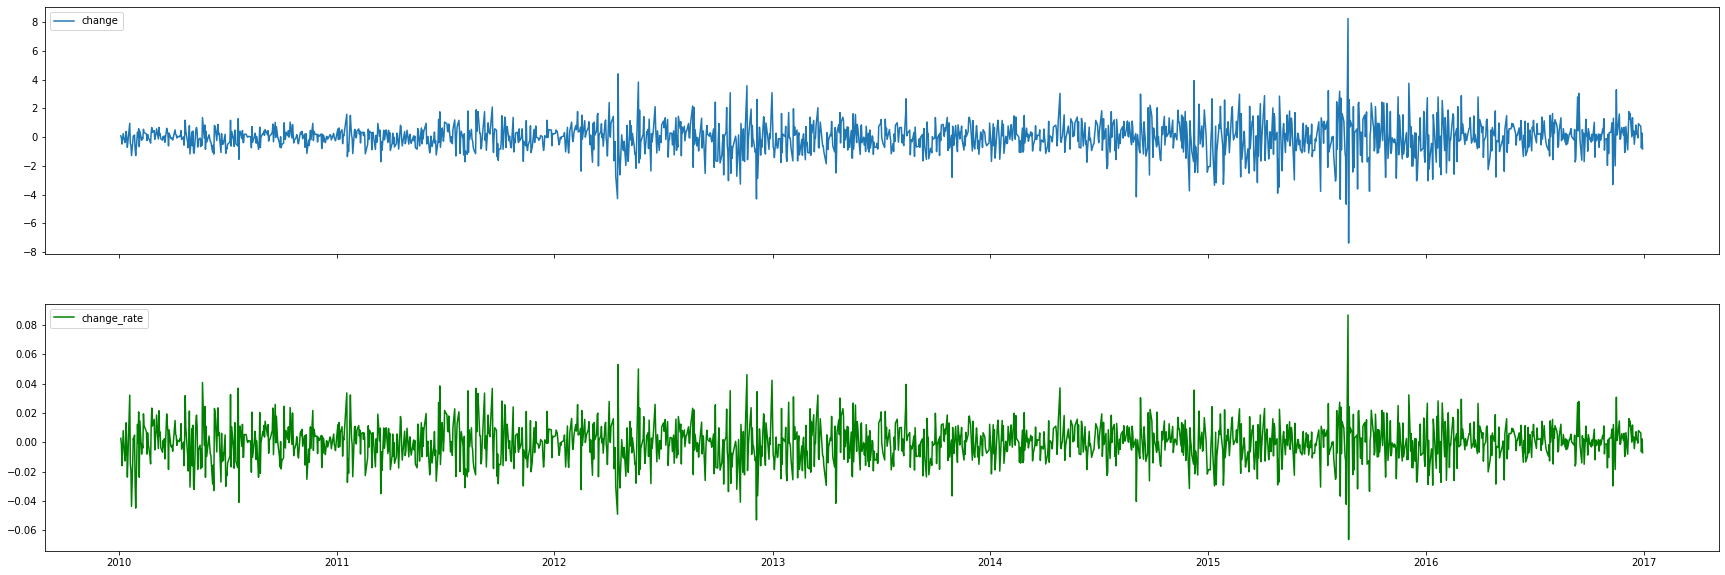

In [65]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(30)
axes[0].plot(df_apple['change'], label='change')
axes[0].legend(loc='upper left')

axes[1].plot(df_apple['change_rate'], label='change_rate', color = 'green')
axes[1].legend(loc='upper left')

From the above plots, we can observe that there are ups and down through out the years

Given the apple stock trend, if we can trade once a day at right before closing, how much money are we ending up with 1 stock ?

In [18]:
df_apple['close_change'] =   df_apple['close'].shift(-1) - df_apple['close']

/var/folders/ly/yp1zttk15gsc1kxg7rl2plgr0000gn/T/ipykernel_6495/1885142278.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apple['close_change'] =   df_apple['close'].shift(-1) - df_apple['close']


In [19]:
df_apple['close_change'] # this rate shows how much gain we will make 
df_apple.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21',
               '2016-12-22', '2016-12-23', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='date', length=1762, freq=None)

In [20]:
import datetime
# + -> + stay
# + -> - sell
# - -> + buy
# - -> - stay

class stock_trad_simulator:

    def __init__(self,stock_symbol):
        self.stock_qty = 1
        self.stock2money = 1
        self.cash = 0
        self.close = 1
        self.total_assest = 1
        self.strategy = ""
        self.money_flow = {'Date':[],'close' : [],'close_change' : [], 'stock_qty':[],'stock2money':[],'cash' : [],'total asset': [], 'strategy' : []}
        self.df_stock = df[df['symbol'] == stock_symbol]
        self.df_stock['close_change'] = self.df_stock['close'].shift(-1) - self.df_stock['close']
        self.df_stock['date'] = pd.to_datetime(self.df_stock['date'], format = '%Y-%m')
        self.df_stock.index = self.df_stock['date']
        del self.df_stock['date']
        self.indexes = self.df_stock.index
        

    def trad_result(self):
        for i in range(len(self.indexes)):
            if self.df_stock['close_change'][self.indexes[i]] >=0 and self.stock_qty !=0: # if increase tmr, and we have stock
                # stay in the stock
                self.stay_in_stock(i)

            elif self.df_stock['close_change'][self.indexes[i]] >= 0 and self.stock_qty == 0:
                self.buy_stock(i)


            elif self.df_stock['close_change'][self.indexes[i]] < 0 and self.stock_qty !=0:
                # sell the stock
                self.sell_stock(i)

            elif self.df_stock['close_change'][self.indexes[i]]<0 and self.stock_qty == 0:
                self.hold_cash(i)

        return pd.DataFrame(self.money_flow)
        
    def daily_update(self,i):
        self.money_flow['Date'].append(self.indexes[i])
        self.money_flow['stock_qty'].append(self.stock_qty)
        self.money_flow['stock2money'].append(self.stock2money)
        self.money_flow['cash'].append(self.cash)
        self.money_flow['close'].append(self.close)
        self.money_flow['close_change'].append(self.close_change)
        self.money_flow['total asset'].append(self.total_assest)
        self.money_flow['strategy'].append(self.strategy)
    
    def stay_in_stock(self,i):

        self.stock2money =  self.df_stock['close'][self.indexes[i]] * self.stock_qty
        self.total_assest = self.stock2money + self.cash
        self.close = self.df_stock['close'][self.indexes[i]]
        self.close_change = self.df_stock['close_change'][self.indexes[i]]
        self.strategy = 'stay in stock'
        self.daily_update(i)


    def buy_stock(self,i):
        self.stock_qty = self.cash /self.df_stock['close'][self.indexes[i]] # end of the day_i I bought all stock
        self.stock2money = self.df_stock['close'][self.indexes[i]] * self.stock_qty
        self.cash = 0
        self.close = self.df_stock['close'][self.indexes[i]]
        self.close_change = self.df_stock['close_change'][self.indexes[i]]
        self.strategy = 'buy the stock'
        self.daily_update(i)

    def sell_stock(self,i):
        self.cash = self.stock_qty * self.df_stock['close'][self.indexes[i]]
        self.close = self.df_stock['close'][self.indexes[i]]
        self.close_change = self.df_stock['close_change'][self.indexes[i]]
        self.stock_qty = 0 # end of the day_i I bought all stock
        self.stock2money = 0
        self.total_assest = self.stock2money + self.cash
        self.strategy = 'sell the stock'
        self.daily_update(i)

    def hold_cash(self,i):
        self.close = self.df_stock['close'][self.indexes[i]]
        self.close_change = self.df_stock['close_change'][self.indexes[i]]
        self.strategy = 'hole the cash'
        self.daily_update(i)

In [21]:
apple_stock_simulator = stock_trad_simulator('AAPL')
df_apple_result = apple_stock_simulator.trad_result()
df_apple_result

/var/folders/ly/yp1zttk15gsc1kxg7rl2plgr0000gn/T/ipykernel_6495/3458794958.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_stock['close_change'] = self.df_stock['close'].shift(-1) - self.df_stock['close']
/var/folders/ly/yp1zttk15gsc1kxg7rl2plgr0000gn/T/ipykernel_6495/3458794958.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_stock['date'] = pd.to_datetime(self.df_stock['date'], format = '%Y-%m')


,Date,close,close_change,stock_qty,stock2money,cash,total asset,strategy
0,2010-01-04,30.572857,0.052856,1.000000,3.057286e+01,0.000000e+00,3.057286e+01,stay in stock
1,2010-01-05,30.625713,-0.487143,0.000000,0.000000e+00,3.062571e+01,3.062571e+01,sell the stock
2,2010-01-06,30.138571,-0.055714,0.000000,0.000000e+00,3.062571e+01,3.062571e+01,hole the cash
3,2010-01-07,30.082857,0.200001,1.018045,3.062571e+01,0.000000e+00,3.062571e+01,buy the stock
4,2010-01-08,30.282858,-0.267143,0.000000,0.000000e+00,3.082932e+01,3.082932e+01,sell the stock
...,...,...,...,...,...,...,...,...
1756,2016-12-22,116.290001,0.229996,18951.587551,2.203880e+06,0.000000e+00,2.203880e+06,buy the stock
1757,2016-12-23,116.519997,0.740005,18951.587551,2.208239e+06,0.000000e+00,2.208239e+06,stay in stock
1758,2016-12-27,117.260002,-0.500000,0.000000,0.000000e+00,2.222263e+06,2.222263e+06,sell the stock
1759,2016-12-28,116.760002,-0.029999,0.000000,0.000000e+00,2.222263e+06,2.222263e+06,hole the cash


From the above result, we can see that we start with a stock(~$30), and by buying and selling the stock based on future stock, we can turn 1 stock into ~19,000 stocks which worth of $2,200,000.

For the future project, I would like to buy and sell stock using Prophet model.

---
## 6. Classify similar stocks based on time series

### 1) K Mean Clustering
### K Mean Clustering based on Close Index Series

In [22]:
# first of all, let's try to simply use K - Mean Clustering
# choose the stock that has covers the full time range from 2010-01-04 to 2016-12-30

len_before = len(df['symbol'].unique())
print(f'before getting rid of the stocks, we have {len_before} companies with {df.shape} rows')
v = df.symbol.value_counts()
df['count'] = df['symbol'].apply(lambda x: v[x])

before getting rid of the stocks, we have 501 companies with (851264, 7) rows


In [23]:
df = df[df['count'] == 1762]
len_after = len(df['symbol'].unique())
print(f'after getting rid of the stocks, we have {len_after} companies with {df.shape} rows')

after getting rid of the stocks, we have 467 companies with (822854, 8) rows


In [24]:
df_kmean = df[['date','symbol','close']]
df_kmean = pd.pivot_table(df_kmean,'close','symbol','date')

In [25]:
df_kmean.head(5)

date,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2016-12-16,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-27,2016-12-28,2016-12-29,2016-12-30
symbol,,,,,,,,,,,,,,,,,,,,,
A,22.389128,22.145923,22.067240,22.038626,22.031474,22.045780,21.781117,21.952789,22.281832,21.766810,...,45.910000,45.430000,46.209999,46.040001,45.970001,46.200001,46.509998,45.720001,45.639999,45.560001
AAL,4.770000,5.310000,5.090000,5.240000,5.140000,5.040000,5.080000,5.480000,5.590000,5.500000,...,47.630001,48.580002,49.220001,49.470001,48.689999,48.480000,48.610001,47.669998,47.250000,46.689999
AAP,40.380001,40.139999,40.490002,40.480000,40.639999,40.240002,39.540001,40.090000,39.560001,39.310001,...,171.910004,173.820007,175.630005,173.509995,170.389999,170.889999,171.839996,170.419998,170.279999,169.119995
AAPL,30.572857,30.625713,30.138571,30.082857,30.282858,30.015715,29.674286,30.092857,29.918571,29.418571,...,115.970001,116.639999,116.949997,117.059998,116.290001,116.519997,117.260002,116.760002,116.730003,115.820000
ABC,26.629999,26.440001,26.190001,25.770000,26.049999,26.340000,26.520000,27.040001,27.209999,26.920000,...,77.379997,78.419998,79.300003,78.849998,77.809998,78.559998,78.820000,78.349998,79.339996,78.190002


In [26]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_kmean)
df_kmean['label'] = kmeans.labels_
df_kmean['label'].value_counts()

0    379
2     81
1      6
3      1
Name: label, dtype: int64

In [27]:
df_kmean.head(5)

date,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-27,2016-12-28,2016-12-29,2016-12-30,label
symbol,,,,,,,,,,,,,,,,,,,,,
A,22.389128,22.145923,22.067240,22.038626,22.031474,22.045780,21.781117,21.952789,22.281832,21.766810,...,45.430000,46.209999,46.040001,45.970001,46.200001,46.509998,45.720001,45.639999,45.560001,0
AAL,4.770000,5.310000,5.090000,5.240000,5.140000,5.040000,5.080000,5.480000,5.590000,5.500000,...,48.580002,49.220001,49.470001,48.689999,48.480000,48.610001,47.669998,47.250000,46.689999,0
AAP,40.380001,40.139999,40.490002,40.480000,40.639999,40.240002,39.540001,40.090000,39.560001,39.310001,...,173.820007,175.630005,173.509995,170.389999,170.889999,171.839996,170.419998,170.279999,169.119995,2
AAPL,30.572857,30.625713,30.138571,30.082857,30.282858,30.015715,29.674286,30.092857,29.918571,29.418571,...,116.639999,116.949997,117.059998,116.290001,116.519997,117.260002,116.760002,116.730003,115.820000,0
ABC,26.629999,26.440001,26.190001,25.770000,26.049999,26.340000,26.520000,27.040001,27.209999,26.920000,...,78.419998,79.300003,78.849998,77.809998,78.559998,78.820000,78.349998,79.339996,78.190002,0


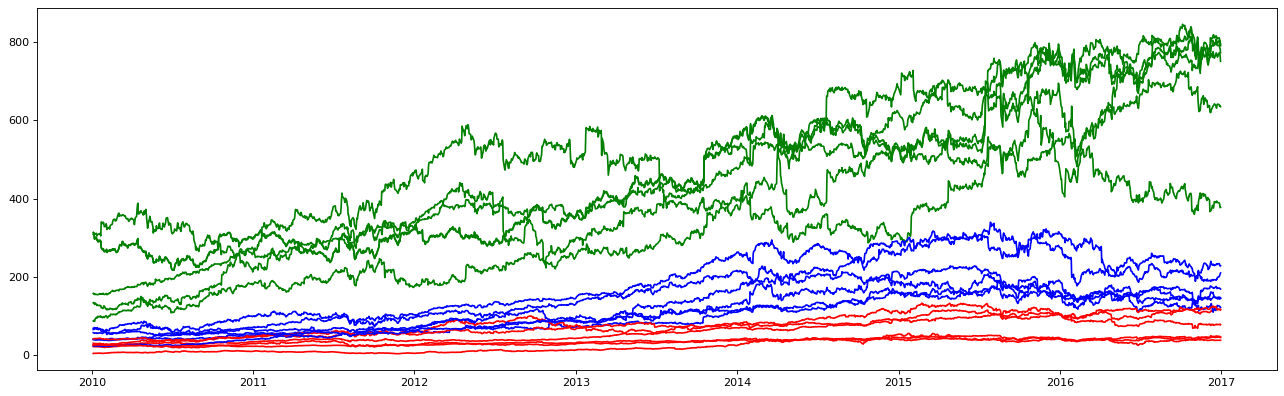

In [28]:
from matplotlib.pyplot import figure
figure(figsize=(20, 6), dpi=80)
for j in range(6):
    for i in range(3):
        df_temp = df_kmean[df_kmean['label'] == i ]
        x = df_temp.columns
        x = x.drop('label')
        x = pd.to_datetime(x)
        y = df_temp.values[j]
        y = y[0:-1]
        if i == 0:
            plt.plot(x,y, color = 'red')
        elif i == 1:
            plt.plot(x,y, color = 'green')
        elif i == 2:
            plt.plot(x,y, color = 'blue')

### K Mean Clustering based on Close_change_rate Index Series

In [29]:
df_kmean_rate = df[['date','symbol','close']]

In [30]:
df_kmean_rate = df_kmean_rate.sort_values(by = ['symbol','date'])
df_kmean_rate

,date,symbol,close
251,2010-01-04,A,22.389128
718,2010-01-05,A,22.145923
1186,2010-01-06,A,22.067240
1654,2010-01-07,A,22.038626
2122,2010-01-08,A,22.031474
...,...,...,...
849260,2016-12-23,ZION,43.860001
849760,2016-12-27,ZION,43.930000
850260,2016-12-28,ZION,43.279999
850760,2016-12-29,ZION,42.790001


In [31]:
df_kmean_rate['close_change'] = df_kmean_rate['close'].pct_change()
df_kmean_rate.close_change[df_kmean_rate['date'] == '2010-01-04'] = np.nan

/var/folders/ly/yp1zttk15gsc1kxg7rl2plgr0000gn/T/ipykernel_6495/1064656382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kmean_rate.close_change[df_kmean_rate['date'] == '2010-01-04'] = np.nan


In [32]:
df_kmean_rate = pd.pivot_table(df_kmean_rate,'close_change','symbol','date')
df_kmean_rate.head(5)

date,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,2010-01-19,...,2016-12-16,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-27,2016-12-28,2016-12-29,2016-12-30
symbol,,,,,,,,,,,,,,,,,,,,,
A,-0.010863,-0.003553,-0.001297,-0.000325,0.000649,-0.012005,0.007882,0.014989,-0.023114,0.012159,...,-0.013961,-0.010455,0.017169,-0.003679,-0.001520,0.005003,0.006710,-0.016986,-0.001750,-0.001753
AAL,0.113208,-0.041431,0.029470,-0.019084,-0.019455,0.007937,0.078740,0.020073,-0.016100,0.025455,...,-0.013872,0.019945,0.013174,0.005079,-0.015767,-0.004313,0.002682,-0.019338,-0.008811,-0.011852
AAP,-0.005944,0.008720,-0.000247,0.003953,-0.009842,-0.017396,0.013910,-0.013220,-0.006320,0.004833,...,-0.005841,0.011110,0.010413,-0.012071,-0.017982,0.002934,0.005559,-0.008263,-0.000821,-0.006812
AAPL,0.001729,-0.015906,-0.001849,0.006648,-0.008822,-0.011375,0.014106,-0.005792,-0.016712,0.044238,...,0.001295,0.005777,0.002658,0.000941,-0.006578,0.001978,0.006351,-0.004264,-0.000257,-0.007796
ABC,-0.007135,-0.009455,-0.016037,0.010865,0.011132,0.006834,0.019608,0.006287,-0.010658,0.016716,...,0.009260,0.013440,0.011222,-0.005675,-0.013190,0.009639,0.003310,-0.005963,0.012636,-0.014495


In [33]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_kmean_rate)
df_kmean['label'] = kmeans.labels_
df_kmean['label'].value_counts()

0    219
1    214
2     34
Name: label, dtype: int64

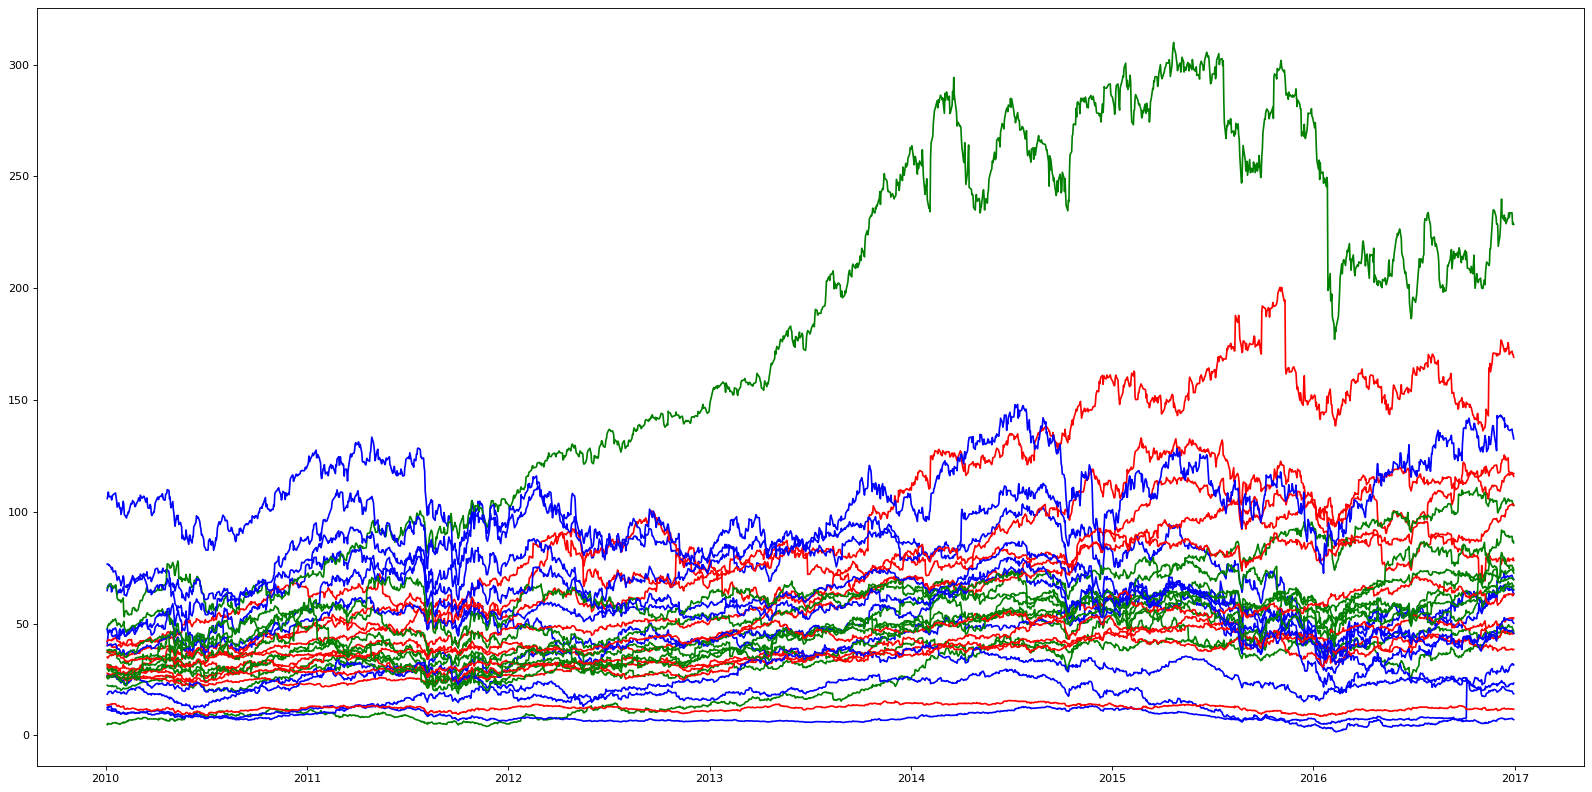

In [34]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)
for j in range(10):
    for i in range(3):
        df_temp = df_kmean[df_kmean['label'] == i ]
        x = df_temp.columns
        x = x.drop('label')
        x = pd.to_datetime(x)
        y = df_temp.values[j]
        y = y[:-1]
        if i == 0:
            plt.plot(x,y, color = 'red')
        elif i == 1:
            plt.plot(x,y, color = 'green')
        elif i == 2:
            plt.plot(x,y, color = 'blue')
plt.tight_layout()

Good, this seems to be capturing the trend behavior better than the earlier method. In the future, we may want to 
1) get the moving average (3 days)
2) get the pct change of moving average
3) cluster based on them

### Find the close stock based on the euclidean distance with the raw index trend

In [35]:
df = df.sort_values(by = ['symbol','date'])
df_ed = pd.pivot_table(df,'close','symbol','date')
df_ed.head(5)

date,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2016-12-16,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-27,2016-12-28,2016-12-29,2016-12-30
symbol,,,,,,,,,,,,,,,,,,,,,
A,22.389128,22.145923,22.067240,22.038626,22.031474,22.045780,21.781117,21.952789,22.281832,21.766810,...,45.910000,45.430000,46.209999,46.040001,45.970001,46.200001,46.509998,45.720001,45.639999,45.560001
AAL,4.770000,5.310000,5.090000,5.240000,5.140000,5.040000,5.080000,5.480000,5.590000,5.500000,...,47.630001,48.580002,49.220001,49.470001,48.689999,48.480000,48.610001,47.669998,47.250000,46.689999
AAP,40.380001,40.139999,40.490002,40.480000,40.639999,40.240002,39.540001,40.090000,39.560001,39.310001,...,171.910004,173.820007,175.630005,173.509995,170.389999,170.889999,171.839996,170.419998,170.279999,169.119995
AAPL,30.572857,30.625713,30.138571,30.082857,30.282858,30.015715,29.674286,30.092857,29.918571,29.418571,...,115.970001,116.639999,116.949997,117.059998,116.290001,116.519997,117.260002,116.760002,116.730003,115.820000
ABC,26.629999,26.440001,26.190001,25.770000,26.049999,26.340000,26.520000,27.040001,27.209999,26.920000,...,77.379997,78.419998,79.300003,78.849998,77.809998,78.559998,78.820000,78.349998,79.339996,78.190002


In [40]:
# we would like to plot the graph that is similar with APPL
apple_series = df_ed.values[list(df_ed.index).index('AAPL')]

distance_list = []
for i in range(len(df_ed.values)):
    distance = ed.distance(apple_series, df_ed.values[i])
    distance_list.append(distance)
df_ed['ed_distance'] = distance_list

df_ed = df_ed.sort_values(by = 'ed_distance')
df_ed.head(5)

date,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-27,2016-12-28,2016-12-29,2016-12-30,ed_distance
symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,30.572857,30.625713,30.138571,30.082857,30.282858,30.015715,29.674286,30.092857,29.918571,29.418571,...,116.639999,116.949997,117.059998,116.290001,116.519997,117.260002,116.760002,116.730003,115.820000,0.000000
AMT,43.459999,44.180000,44.410000,44.290001,44.380001,43.980000,43.439999,44.360001,44.610001,44.000000,...,106.949997,106.980003,106.599998,106.599998,106.029999,106.290001,105.839996,106.389999,105.680000,568.676341
SRE,55.900002,54.709999,53.959999,53.840000,53.810001,54.590000,54.400002,53.869999,53.599998,52.419998,...,103.519997,103.099998,101.839996,102.129997,101.669998,101.230003,99.919998,100.989998,100.639999,603.003324
TRV,49.810001,48.630001,47.939999,48.630001,48.560001,48.540001,48.849998,49.020000,49.279999,48.790001,...,121.750000,122.440002,122.570000,122.120003,122.120003,121.980003,122.080002,122.290001,122.419998,612.491013
INTU,30.809999,30.809999,30.379999,30.280001,31.080000,31.219999,31.219999,31.580000,31.780001,31.459999,...,118.150002,118.389999,117.690002,116.910004,116.919998,116.900002,115.459999,114.919998,114.610001,616.044483


Compare 5 stocks that are close with AAPL stock

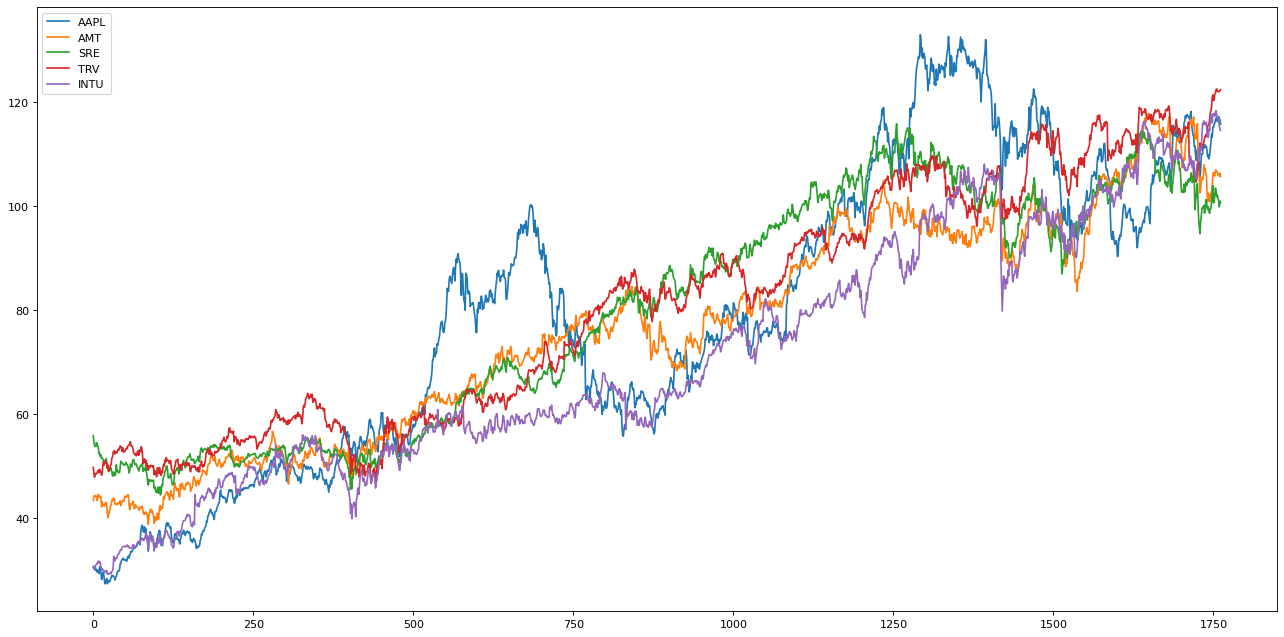

In [42]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)
plt.plot(df_ed.values[0][:-1])
plt.plot(df_ed.values[1][:-1])
plt.plot(df_ed.values[2][:-1])
plt.plot(df_ed.values[3][:-1])
plt.plot(df_ed.values[4][:-1])

plt.legend([df_ed.index[0], df_ed.index[1],df_ed.index[2],df_ed.index[3],df_ed.index[4] ])


Compare 5 stocks that are opposite with AAPL stock

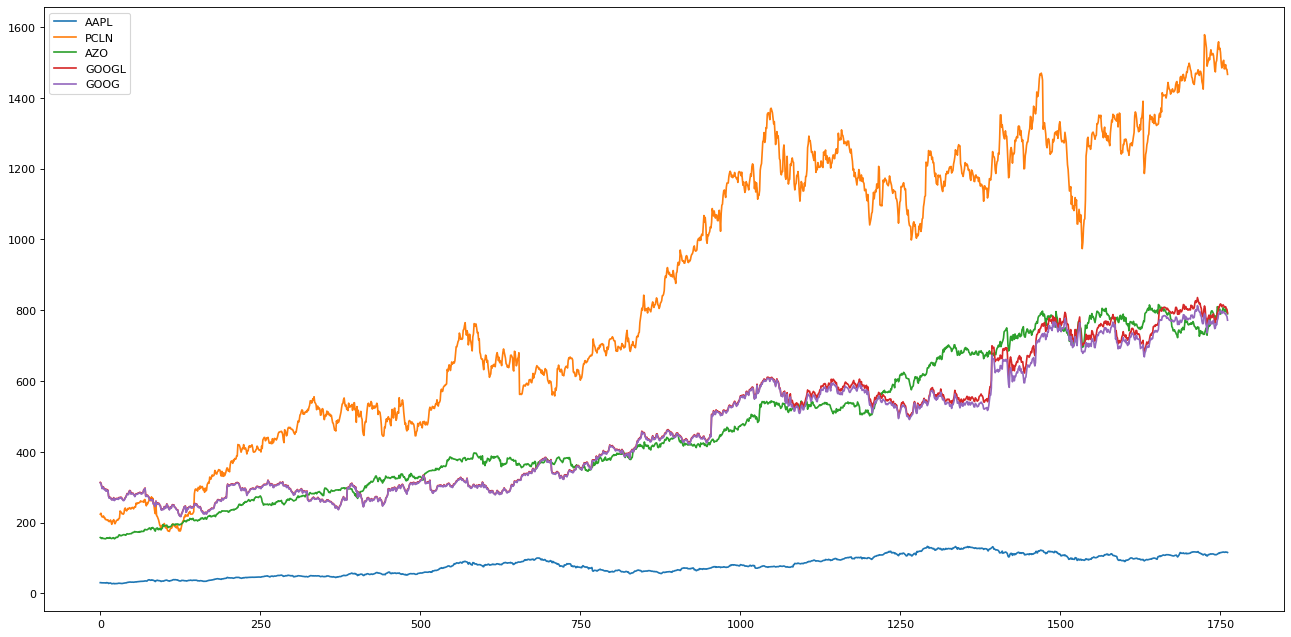

In [43]:
figure(figsize=(20, 10), dpi=80)
plt.plot(df_ed.values[0][:-1])
plt.plot(df_ed.values[-1][:-1])
plt.plot(df_ed.values[-2][:-1])
plt.plot(df_ed.values[-3][:-1])
plt.plot(df_ed.values[-4][:-1])

plt.legend([df_ed.index[0], df_ed.index[-1],df_ed.index[-2],df_ed.index[-3],df_ed.index[-4] ])

### Find the close stock based on the euclidean distance with the index change rate

In [44]:
df_kmean_rate

date,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,2010-01-19,...,2016-12-16,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-27,2016-12-28,2016-12-29,2016-12-30
symbol,,,,,,,,,,,,,,,,,,,,,
A,-0.010863,-0.003553,-0.001297,-0.000325,0.000649,-0.012005,0.007882,0.014989,-0.023114,0.012159,...,-0.013961,-0.010455,0.017169,-0.003679,-0.001520,0.005003,0.006710,-0.016986,-0.001750,-0.001753
AAL,0.113208,-0.041431,0.029470,-0.019084,-0.019455,0.007937,0.078740,0.020073,-0.016100,0.025455,...,-0.013872,0.019945,0.013174,0.005079,-0.015767,-0.004313,0.002682,-0.019338,-0.008811,-0.011852
AAP,-0.005944,0.008720,-0.000247,0.003953,-0.009842,-0.017396,0.013910,-0.013220,-0.006320,0.004833,...,-0.005841,0.011110,0.010413,-0.012071,-0.017982,0.002934,0.005559,-0.008263,-0.000821,-0.006812
AAPL,0.001729,-0.015906,-0.001849,0.006648,-0.008822,-0.011375,0.014106,-0.005792,-0.016712,0.044238,...,0.001295,0.005777,0.002658,0.000941,-0.006578,0.001978,0.006351,-0.004264,-0.000257,-0.007796
ABC,-0.007135,-0.009455,-0.016037,0.010865,0.011132,0.006834,0.019608,0.006287,-0.010658,0.016716,...,0.009260,0.013440,0.011222,-0.005675,-0.013190,0.009639,0.003310,-0.005963,0.012636,-0.014495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XRX,0.001159,-0.009259,0.004673,-0.003488,0.024504,0.007973,0.011299,-0.006704,-0.005624,0.020362,...,0.011074,0.000000,0.010953,-0.015168,-0.008801,-0.006659,-0.001117,-0.020134,-0.004566,0.001147
YHOO,0.007602,-0.003482,-0.027373,0.000000,0.002395,-0.003584,0.013189,0.013018,-0.017523,-0.004162,...,0.005207,-0.004921,0.019261,-0.000255,-0.016603,0.004156,0.006725,-0.004882,-0.002324,0.000776
YUM,-0.003420,-0.007149,-0.000288,0.000288,0.017281,0.018969,-0.002779,0.010866,-0.016814,-0.000561,...,0.006895,-0.003268,0.002811,-0.000467,-0.002181,-0.003747,0.003448,-0.004841,-0.001412,-0.004715


In [48]:
# we would like to plot the graph that is similar with APPL
apple_series = df_kmean_rate.values[list(df_kmean_rate.index).index('AAPL')]
distance_list = []

for i in range(len(df_kmean_rate.values)):
    distance = ed.distance(apple_series, df_kmean_rate.values[i])
    distance_list.append(distance)
df_kmean_rate['ed_distance'] = distance_list

df_kmean_rate = df_kmean_rate.sort_values(by = 'ed_distance')
df_kmean_rate.head(5)

date,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,2010-01-19,...,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-27,2016-12-28,2016-12-29,2016-12-30,ed_distance
symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.001729,-0.015906,-0.001849,0.006648,-0.008822,-0.011375,0.014106,-0.005792,-0.016712,0.044238,...,0.005777,0.002658,0.000941,-0.006578,0.001978,0.006351,-0.004264,-0.000257,-0.007796,0.000000
ADP,-0.005370,-0.002347,-0.000471,-0.001412,0.004479,-0.007041,0.007327,-0.002816,-0.005412,0.015141,...,0.002380,0.012266,0.001368,0.001269,0.003216,0.003692,-0.002517,0.003882,-0.006477,0.656858
MMM,-0.006264,0.014182,0.000717,0.007046,-0.004032,0.000834,-0.003212,-0.003342,-0.001557,0.020991,...,0.004001,0.002750,-0.001231,0.004315,-0.002511,0.000951,-0.004695,0.001853,0.000897,0.668497
L,0.005379,0.006956,0.007439,-0.000791,0.000792,-0.007911,0.007974,-0.000264,-0.018465,0.025531,...,-0.001263,0.006114,0.003772,-0.004593,-0.003565,-0.001473,-0.005270,-0.005086,-0.002556,0.671436
FISV,0.004248,-0.004230,-0.004653,-0.011179,0.005344,-0.008792,0.008457,-0.002864,-0.016615,0.015019,...,0.002990,0.016022,-0.004584,-0.008842,0.003624,0.001296,-0.008692,0.000746,-0.009321,0.674431


AAPL
ADP
MMM
L
FISV


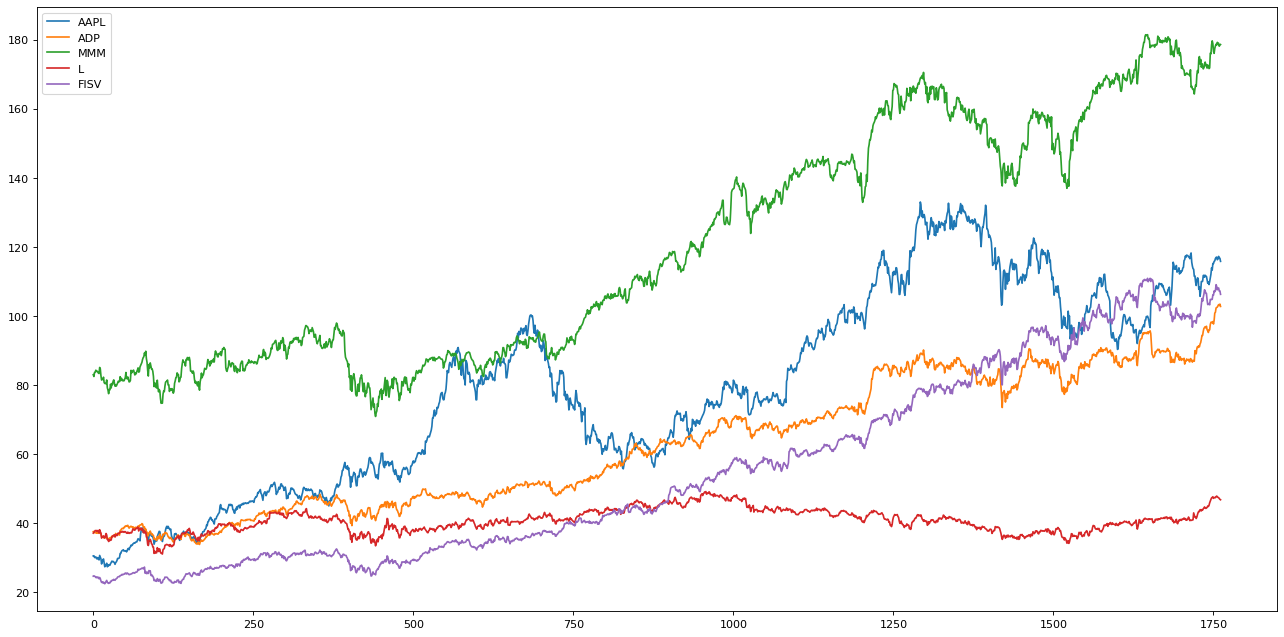

In [49]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)
for i in range(5):
    print(df_kmean_rate.index[i])
    plt.plot(df_kmean.loc[df_kmean_rate.index[i]][:-1].values)

plt.legend([df_kmean_rate.index[0], df_kmean_rate.index[1],df_kmean_rate.index[2],df_kmean_rate.index[3],df_kmean_rate.index[4] ])


AAPL
ARNC
NFLX
CHK
FSLR


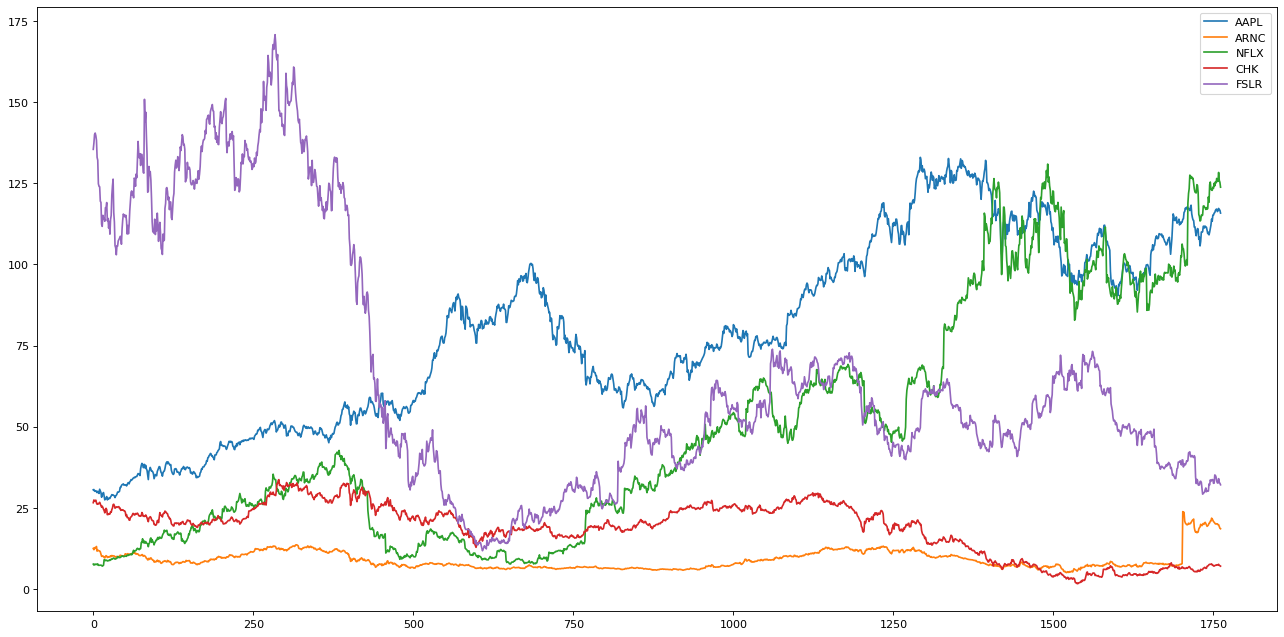

In [50]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)
for i in range(0,5):
    print(df_kmean_rate.index[-i])
    plt.plot(df_kmean.loc[df_kmean_rate.index[-i]][:-1].values)


plt.legend([df_kmean_rate.index[0],df_kmean_rate.index[-1], df_kmean_rate.index[-2],df_kmean_rate.index[-3],df_kmean_rate.index[-4],df_kmean_rate.index[-5] ])


### let me try to compare each stock with the "rate change of moving average"


In [51]:
df_rcma = df[['date','symbol','close']]

In [53]:
list_of_index = df_rcma.symbol.unique()
rolling_mean_list = []
for index in list_of_index:
    temp = df_rcma[df_rcma['symbol'] == index]
    rolling_mean = temp['close'].rolling(15).mean()
    rolling_mean_list.extend(rolling_mean.values)

In [56]:
df_rcma['rolling_avg'] = rolling_mean_list
df_rcma['rolling_avg_change'] = df_rcma['rolling_avg'].pct_change()

/var/folders/ly/yp1zttk15gsc1kxg7rl2plgr0000gn/T/ipykernel_6495/143705462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rcma['rolling_avg'] = rolling_mean_list
/var/folders/ly/yp1zttk15gsc1kxg7rl2plgr0000gn/T/ipykernel_6495/143705462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rcma['rolling_avg_change'] = df_rcma['rolling_avg'].pct_change()


In [57]:
df_rcma = pd.pivot_table(df_rcma,'rolling_avg_change','symbol','date')

In [58]:
df_rcma

date,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2016-12-16,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-27,2016-12-28,2016-12-29,2016-12-30
symbol,,,,,,,,,,,,,,,,,,,,,
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001509,0.002704,0.002549,0.003027,0.004044,0.003167,0.002880,0.001276,0.000942,-0.000347
AAL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001143,0.002932,0.003275,0.004245,0.004101,0.003306,0.004002,0.001710,-0.001927,-0.001876
AAP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000406,0.001180,0.002253,0.001461,-0.000142,0.000289,0.000504,-0.001112,-0.002503,-0.002857
AAPL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002488,0.003010,0.003249,0.003858,0.003996,0.003875,0.004752,0.003952,0.003295,0.002132
ABC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.001016,-0.000538,0.001428,0.000734,0.000009,-0.000205,-0.000614,-0.000444,0.002529,0.001116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XRX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.001781,-0.002641,-0.001646,-0.001864,-0.003160,-0.003963,-0.002749,-0.003917,-0.005534,-0.005785
YHOO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.003701,-0.004981,-0.004031,-0.003102,-0.001880,-0.002351,-0.002139,-0.002076,-0.003155,-0.004612
YUM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000953,0.000973,0.000710,0.000835,0.001419,0.001448,0.001009,0.000270,-0.000841,-0.001071


In [59]:
# we would like to plot the graph that is similar with APPL
apple_series = df_rcma.values[list(df_rcma.index).index('AAPL')]

distance_list = []
for i in range(len(df_rcma.values)):
    distance = ed.distance(apple_series, df_rcma.values[i])
    distance_list.append(distance)
df_rcma['ed_distance'] = distance_list

df_rcma = df_rcma.sort_values(by = 'ed_distance')
df_rcma.head(5)

date,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-27,2016-12-28,2016-12-29,2016-12-30,ed_distance
symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003010,0.003249,0.003858,0.003996,0.003875,0.004752,0.003952,0.003295,0.002132,0.000000
APH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000481,-0.000098,-0.000039,0.001512,0.000941,0.000480,-0.000029,-0.000460,-0.001597,0.175528
CINF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000112,-0.000517,-0.000474,-0.000716,-0.000337,-0.000225,-0.000994,-0.001859,-0.002166,0.178475
TJX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.001466,-0.001022,-0.000765,-0.001058,-0.000568,-0.000930,-0.001837,-0.002143,-0.002468,0.178629
USB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003892,0.004490,0.003314,0.002280,0.002843,0.002513,0.001350,-0.000077,-0.000680,0.179454


AAPL
APH
CINF
TJX
USB


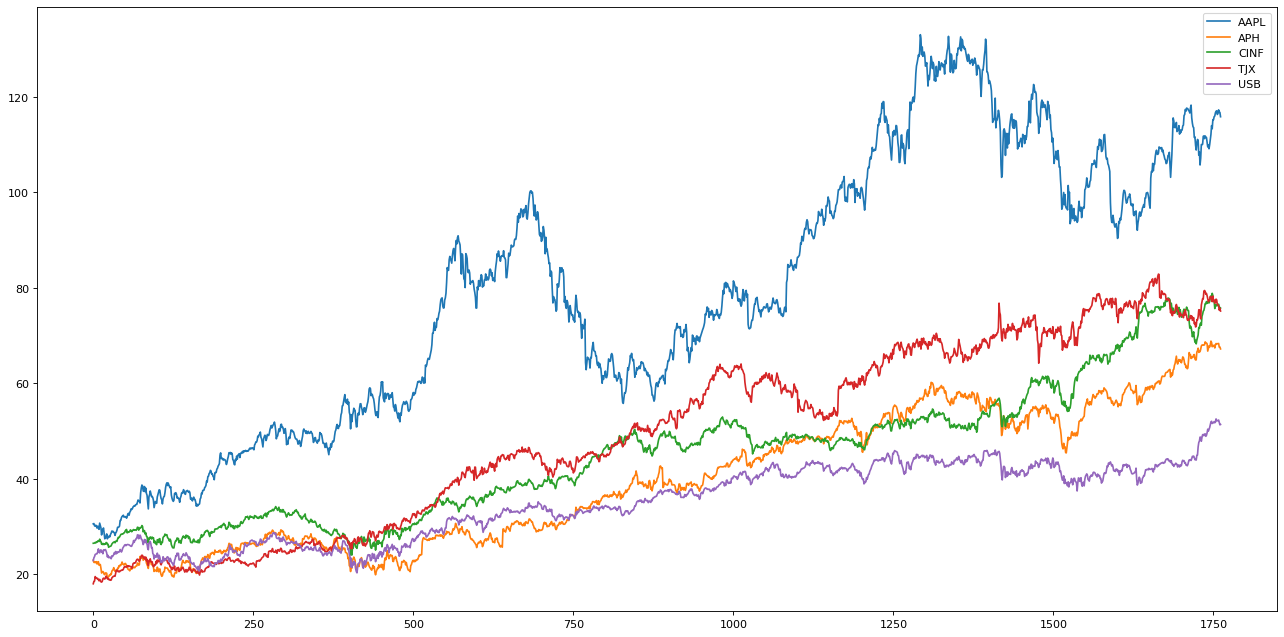

In [60]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)
for i in range(5):
    print(df_rcma.index[i])
    plt.plot(df_kmean.loc[df_rcma.index[i]][:-1].values)


plt.legend([df_rcma.index[0], df_rcma.index[1],df_rcma.index[2],df_rcma.index[3],df_rcma.index[4] ])


## 7. Conclusion

1. To find the time series clusters based on the magnitude -> k mean cluster with raw trend
2. To find the time series clusters based on the shape of the trend -> k mean cluster with percent change
3. To find the time series that has similar magnitude with a trend -> find trends with the closest euclidean distance / Dynamic Time warping
3. To find the time series that has similar shape with a trend -> get the moving average and get the rate changes. Find trends with the closest euclidean distance / Dynamic Time warping.

## 8. Bonus Page
Which stock grow the most in percentage wise?

In [61]:
df_kmean_rate = df_kmean_rate.drop('ed_distance', axis = 1)

In [63]:
stock_trend = {}
I = len(df_kmean_rate.index)
J = len(df_kmean_rate.columns)
for i in range(I):
    a_series = []
    mag = 1
    for j in range(J):
        if df_kmean_rate.iloc[i][j] >0:
            mag = mag * (1+ df_kmean_rate.iloc[i][j])
        elif df_kmean_rate.iloc[i][j] <0:
            mag = mag * (1+df_kmean_rate.iloc[i][j])
        a_series.append(mag)
    stock_trend[df_kmean_rate.index[i]] = a_series

In [64]:
df_trend = pd.DataFrame(stock_trend)
df_trend = df_trend.transpose()
df_trend = df_trend.sort_values(by = 1760, ascending= False).head(20)

NFLX
REGN
ULTA
URI
ALK
AAL
STZ
AVGO
ORLY
MNST
PCLN
EXR
AYI
FL
ROST
TSO
NVDA
UAL
TSCO
AMZN


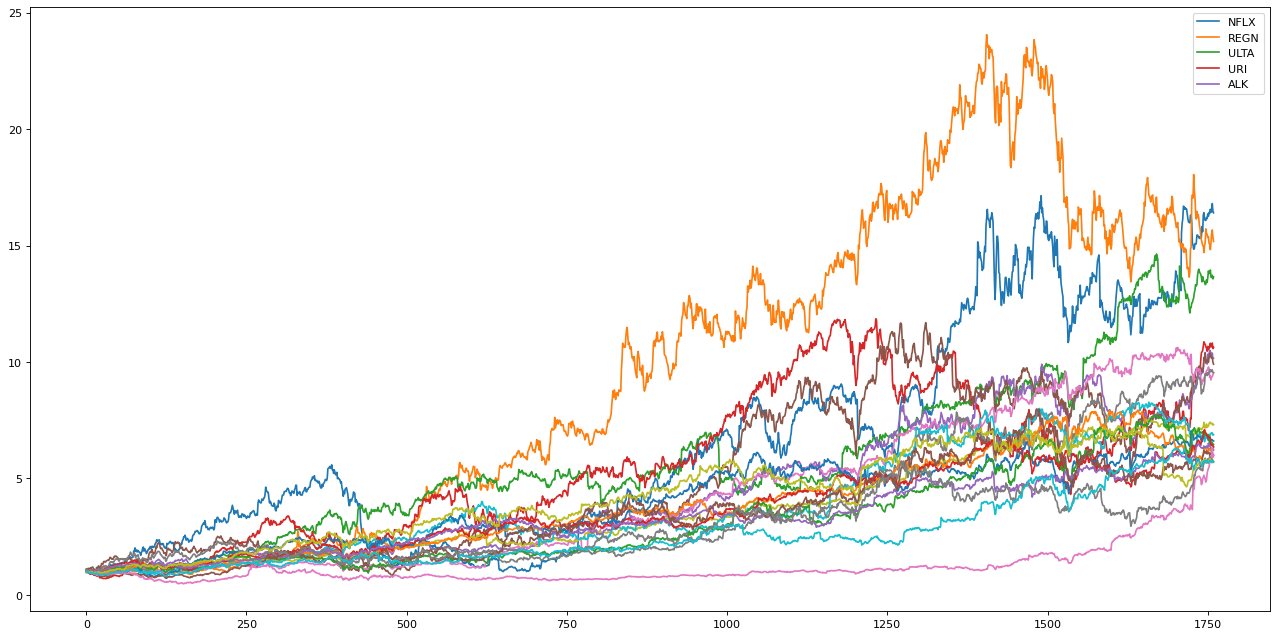

In [65]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)
for i in range(20):
    print(df_trend.index[i])
    plt.plot(df_trend.iloc[i][:-1])

plt.legend([df_trend.index[0], df_trend.index[1],df_trend.index[2],df_trend.index[3],df_trend.index[4] ])